# Rotman Data Science Competition
## Section 1.1: Exploratory Data Analysis of Data Over Time

# Table of Contents
0. [Quick Competition Data Preview](#Section_0)
1. [Identifying Trends Over Time](#Section_1)
    1. [Identifying Trends in Department Sales](#Section_1.1)
    2. [Identifying Trends in Aisle Sales](#Section_1.2)
2. [Kaggle Data Analysis](#Section_2)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
SHOW_GRAPHS = False

## 0. Quick Competition Data Preview <a class="anchor" id="Section_0"></a>

In [3]:
def load_competition_data() -> pd.DataFrame:
    DATA_PATH = "data/mma_mart.csv"
    data = pd.read_csv(DATA_PATH)
    return data

GRAPH_OUT_PATH = "graphs/"

In [4]:
mma_data = load_competition_data()
mma_data.head()

,order_id,product_id,product_name,aisle_id,aisle,department_id,department
0,1,49302,Bulgarian Yogurt,120,yogurt,16,dairy eggs
1,1,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,other creams cheeses,16,dairy eggs
2,1,10246,Organic Celery Hearts,83,fresh vegetables,4,produce
3,1,49683,Cucumber Kirby,83,fresh vegetables,4,produce
4,1,43633,Lightly Smoked Sardines in Olive Oil,95,canned meat seafood,15,canned goods


In [5]:
mma_data.shape

(987259, 7)

In [6]:
mma_data.nunique()

order_id         97833
product_id       35070
product_name     35070
aisle_id           134
aisle              134
department_id       21
department          21
dtype: int64

In [7]:
mma_data.groupby("department")["department"].count()

department
alcohol              4580
babies              12872
bakery              35806
beverages           81923
breakfast           21585
bulk                 1087
canned goods        32486
dairy eggs         164468
deli                32008
dry goods pasta     26096
frozen              68202
household           22445
international        8248
meat seafood        21588
missing              2289
other                1097
pantry              56681
personal care       13773
pets                 3157
produce            288775
snacks              88093
Name: department, dtype: int64

In [8]:
mma_data.groupby("aisle")["aisle"].count()

aisle
air fresheners candles             592
asian foods                       5229
baby accessories                   242
baby bath body care                232
baby food formula                11660
                                 ...  
trash bags liners                 1051
vitamins supplements              1410
water seltzer sparkling water    25354
white wines                        916
yogurt                           43857
Name: aisle, Length: 134, dtype: int64

## 1. Analyzing Competition Data Over Time <a class="anchor" id="Section_1"></a>
### a) Identifying Trends in Department Sales <a class="anchor" id="Section_1.1"></a>
Get department sales over order ids

In [9]:
# Get relevant data for analysis of trends in department sales
dep_analysis = mma_data.loc[:, ["order_id", "department"]]

# Get department names
departments = dep_analysis["department"].unique()

# dep_analysis.head()

In [10]:
# Make table of order ids to departments
order_id_by_department = dep_analysis.pivot_table(index="order_id", columns="department", aggfunc="size")
order_id_by_department.fillna(0, inplace=True)
# order_id_by_department.head()

Turn order ids into days. Currently using the crude method of assuming a constant number of orders per day.

In [11]:
ORDERS_PER_DAY = 500
# Edit pivot table to make index days
order_id_by_department["t"] = np.ceil(order_id_by_department.index / ORDERS_PER_DAY)
time_to_dep_sales = order_id_by_department.groupby("t").sum()
# time_to_dep_sales.head()

Let's plot the sales of each department over time!

In [12]:
# Plot figures of department sales over time, with a different line for each department
fig, ax = plt.subplots(figsize=(30, 30))

# Set x and y labels
ax.set(xlabel="Days", ylabel="Sales")

# Plot figures
for dep in departments:
    ax.plot(time_to_dep_sales.index, time_to_dep_sales[dep], label=dep)
    ax.scatter(time_to_dep_sales.index, time_to_dep_sales[dep], label=dep)

# Add legend
ax.legend()
fig.savefig(GRAPH_OUT_PATH + f"department_sales_t_{ORDERS_PER_DAY}.png")

if SHOW_GRAPHS:
    plt.show()
else:
    plt.close();

Examine departments with less sales by plotting them on a separate graph

In [13]:
time_to_dep_sales.sort_values(axis=1, by=10.0, inplace=True)
# time_to_dep_sales.head()

In [14]:
# Plot figures of department sales over time but with smaller departments on different graph
ROWS = 4
fig, axes = plt.subplots(nrows=ROWS, figsize=(ROWS * 10, ROWS * 10))

# Set x and y labels
for ax in axes:
    ax.set(xlabel="Days", ylabel="Sales")

# Plot figures
sorted_deps = time_to_dep_sales.columns[:-2]
for dep_id in range(len(sorted_deps)):
    dep = sorted_deps[dep_id]
    if dep_id < len(sorted_deps) / 4:
        ax = axes[0]
    elif dep_id < len(sorted_deps) / 2:
        ax = axes[1]
    elif dep_id < 3 * len(sorted_deps) / 4:
        ax = axes[2]
    else:
        ax = axes[3]
    ax.plot(time_to_dep_sales.index, time_to_dep_sales[dep], label=dep)
    ax.scatter(time_to_dep_sales.index, time_to_dep_sales[dep], label=dep)
# Add legends
for ax in axes:
    ax.legend()

fig.savefig(GRAPH_OUT_PATH + f"department_sales_t_{ORDERS_PER_DAY}_split_by_size.png")

if SHOW_GRAPHS:
    plt.show()
else:
    plt.close();

Instead of connecting the points, try fitting a curve to the data

In [15]:
def p4(x: float, a1: float, a2: float, a3: float, a4: float, c: float) -> float:
    """Returns the value of a fourth degree polynomial with coefficients a1, a2, a3, a4, and c at x"""
    return a1 * x ** 4 + a2 * x ** 3 + a3 * x ** 2 + a4 * x + c

def p10(x: float, a1: float, a2: float, a3: float, a4: float, a5: float, a6: float, a7: float, a8: float, a9: float, a10: float, c: float) -> float:
    """Returns the value of a tenth degree polynomial with coefficients a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, and c at x"""
    return a1 * x ** 10 + a2 * x ** 9 + a3 * x ** 8 + a4 * x ** 7 + a5 * x ** 6 + a6 * x ** 5 + a7 * x ** 4 + a8 * x ** 3 + a9 * x ** 2 + a10 * x + c

In [16]:
# fitted_params_p4 = curve_fit(p4, time_to_dep_sales.index, time_to_dep_sales["produce"])
fitted_params_p10 = curve_fit(p10, time_to_dep_sales.index, time_to_dep_sales["produce"])
produce_trend_line = [p10(x, *fitted_params_p10[0]) for x in time_to_dep_sales.index]

Plot the produce trend line along with produce scatter plot

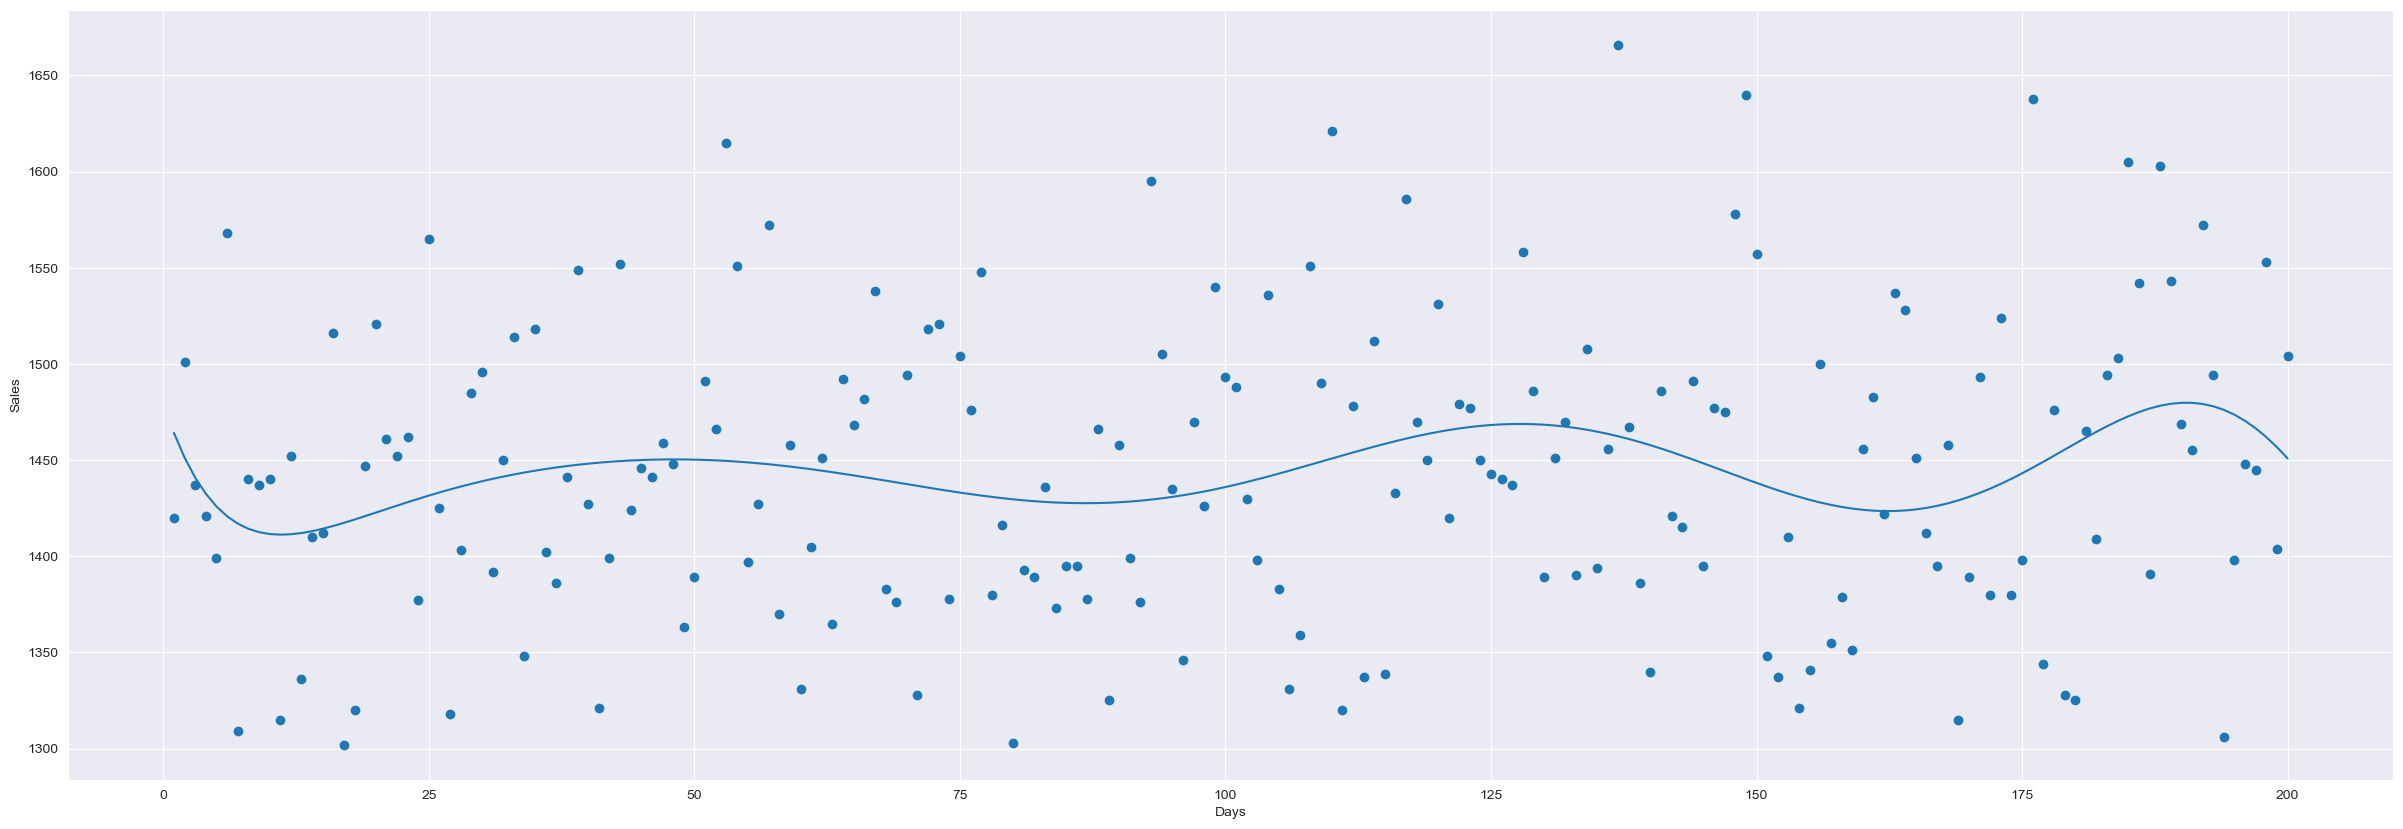

In [17]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set(xlabel="Days", ylabel="Sales")

ax.scatter(time_to_dep_sales.index, time_to_dep_sales["produce"], label="produce")
ax.plot(time_to_dep_sales.index, produce_trend_line)
plt.legend
plt.show()

Do this for all the departments

In [18]:
trendlines = []
for dep in sorted_deps:
    fitted_params_p10 = curve_fit(p10, time_to_dep_sales.index, time_to_dep_sales[dep])
    trendlines.append([p10(x, *fitted_params_p10[0]) for x in time_to_dep_sales.index])

In [19]:
# Plot figures of department sales over time but with smaller departments on different graph
ROWS = 4
fig, axes = plt.subplots(nrows=ROWS, figsize=(ROWS * 10, ROWS * 10))

# Set x and y labels
for ax in axes:
    ax.set(xlabel="Days", ylabel="Sales")

# Plot figures
sorted_deps = time_to_dep_sales.columns[:-2]
for dep_id in range(len(sorted_deps)):
    dep = sorted_deps[dep_id]
    if dep_id < len(sorted_deps) / 4:
        ax = axes[0]
    elif dep_id < len(sorted_deps) / 2:
        ax = axes[1]
    elif dep_id < 3 * len(sorted_deps) / 4:
        ax = axes[2]
    else:
        ax = axes[3]

    # Plot trend line
    ax.plot(time_to_dep_sales.index, trendlines[dep_id], label=dep)

    # Plot data
    ax.scatter(time_to_dep_sales.index, time_to_dep_sales[dep], label=dep)
# Add legends
for ax in axes:
    ax.legend()

fig.savefig(GRAPH_OUT_PATH + f"department_sales_trendlines_t_{ORDERS_PER_DAY}.png")
if SHOW_GRAPHS:
    plt.show()
else:
    plt.close();

Notice that the data is extremely noisy and no clear trend is present.

### b) Identifying Trends in Aisle Sales <a class="anchor" id="Section_1.2"></a>
Repeat process but for aisles

In [20]:
# Get relevant data for analysis of trends in aisle sales
aisle_analysis = mma_data.loc[:, ["order_id", "aisle"]]
aisle_analysis.head()

,order_id,aisle
0,1,yogurt
1,1,other creams cheeses
2,1,fresh vegetables
3,1,fresh vegetables
4,1,canned meat seafood


In [21]:
# Make table of order ids to aisles
order_id_by_aisle = aisle_analysis.pivot_table(index="order_id", columns="aisle", aggfunc="size")
order_id_by_aisle.fillna(0, inplace=True)
order_id_by_aisle.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
order_id_by_aisle.shape

(97833, 134)

In [23]:
# Make index days
ORDERS_PER_DAY = int(order_id_by_aisle.shape[0] / 365)

order_id_by_aisle["t"] = np.ceil(order_id_by_aisle.index / ORDERS_PER_DAY)
time_to_aisle_sales = order_id_by_aisle.groupby("t").sum()
time_to_aisle_sales.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
t,,,,,,,,,,,,,,,,,,,,,
1.0,2.0,13.0,1.0,2.0,29.0,4.0,24.0,1.0,1.0,1.0,...,21.0,22.0,13.0,11.0,6.0,4.0,2.0,68.0,0.0,94.0
2.0,0.0,14.0,1.0,1.0,38.0,0.0,39.0,2.0,0.0,5.0,...,20.0,18.0,15.0,20.0,2.0,6.0,2.0,89.0,0.0,106.0
3.0,1.0,22.0,1.0,0.0,29.0,3.0,26.0,0.0,0.0,2.0,...,36.0,26.0,6.0,20.0,3.0,3.0,3.0,61.0,2.0,100.0
4.0,1.0,17.0,0.0,0.0,28.0,2.0,30.0,0.0,0.0,0.0,...,46.0,23.0,13.0,10.0,2.0,3.0,2.0,70.0,1.0,131.0
5.0,3.0,13.0,3.0,0.0,22.0,3.0,34.0,2.0,0.0,2.0,...,21.0,21.0,10.0,13.0,2.0,2.0,4.0,65.0,2.0,120.0


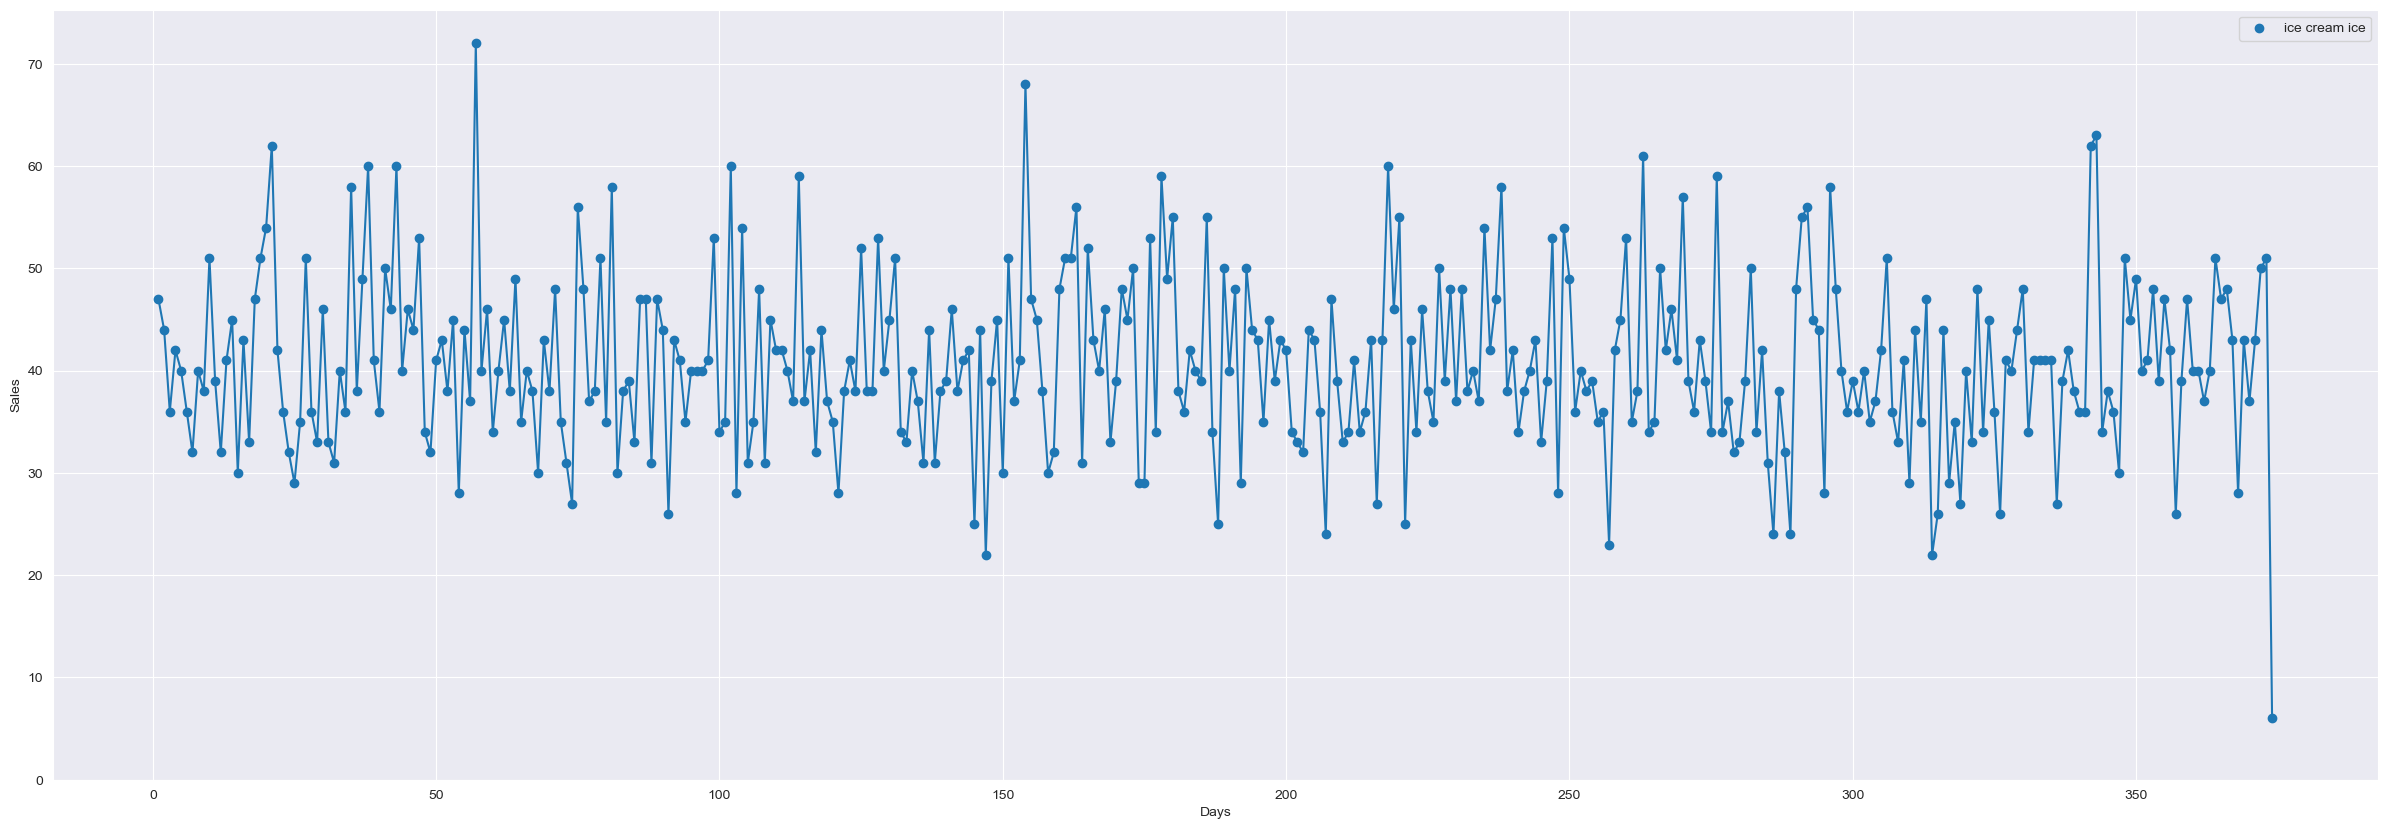

In [24]:
# Plot figures of ice cream sales over time
fig, ax = plt.subplots(figsize=(30, 10))

ax.plot(time_to_aisle_sales.index, time_to_aisle_sales["ice cream ice"])
ax.scatter(time_to_aisle_sales.index, time_to_aisle_sales["ice cream ice"], label="ice cream ice")

ax.set(xlabel="Days", ylabel="Sales")
ax.legend()
ax.set_ylim(bottom=0)

plt.show()

In [25]:
# Plot figures of aisle sales over time, with a different line for each aisle
fig, ax = plt.subplots(figsize=(30, 30))
for aisle in time_to_aisle_sales.columns:
    ax.plot(time_to_aisle_sales.index, time_to_aisle_sales[aisle], label=aisle)
    ax.scatter(time_to_aisle_sales.index, time_to_aisle_sales[aisle])

ax.set(xlabel="Days", ylabel="Sales")
ax.legend()

fig.savefig(GRAPH_OUT_PATH + f"all_aisle_sales_t_{ORDERS_PER_DAY}.png")

if SHOW_GRAPHS:
    plt.show()
else:
    plt.close();

In [26]:
time_to_aisle_sales.sort_values(axis=1, by=10.0, inplace=True)

In [27]:
# Plot figures of aisle sales over time but with smaller aisles on different graphs
ROWS = 10
COLUMNS = 10
fig, axes = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=(ROWS * 15, ROWS * 15))

# Set x and y labels
for axes_row in axes:
    for ax in axes_row:
        ax.set(xlabel="Days", ylabel="Sales")

# Plot figures
sorted_aisles = time_to_aisle_sales.columns
for aisle_id in range(len(sorted_aisles)):
    aisle = sorted_aisles[aisle_id]

    category_found = False
    for i in range(ROWS):
        for j in range(COLUMNS):
            idx = i * COLUMNS + j
            if aisle_id < (idx + 1) * len(sorted_aisles) / (ROWS * COLUMNS):
                ax = axes[i][j]
                category_found = True
                break
        if category_found:
            break

    ax.plot(time_to_aisle_sales.index, time_to_aisle_sales[aisle])
    ax.scatter(time_to_aisle_sales.index, time_to_aisle_sales[aisle], label=aisle)

# Add legends
for axes_row in axes:
    for ax in axes_row:
        ax.set_ylim(bottom=0)
        ax.legend()

fig.savefig(GRAPH_OUT_PATH + f"aisle_sales_t_{ORDERS_PER_DAY}.png")

if SHOW_GRAPHS:
    plt.show()
else:
    plt.close();

Fit a curve to the data to explore trends

In [28]:
trendlines = []
for aisle in sorted_aisles:
    fitted_params_p10 = curve_fit(p10, time_to_aisle_sales.index, time_to_aisle_sales[aisle])
    trendlines.append([p10(x, *fitted_params_p10[0]) for x in time_to_aisle_sales.index])

In [29]:
# Plot the trendlines
ROWS = 10
COLUMNS = 10
fig, axes = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=(ROWS * 15, ROWS * 15))

# Set x and y labels
for axes_row in axes:
    for ax in axes_row:
        ax.set(xlabel="Days", ylabel="Sales")

# Plot figures
sorted_aisles = time_to_aisle_sales.columns
for aisle_id in range(len(sorted_aisles)):
    aisle = sorted_aisles[aisle_id]

    category_found = False
    for i in range(ROWS):
        for j in range(COLUMNS):
            idx = i * COLUMNS + j
            if aisle_id < (idx + 1) * len(sorted_aisles) / (ROWS * COLUMNS):
                ax = axes[i][j]
                category_found = True
                break
        if category_found:
            break

    # Plot trend line
    ax.plot(time_to_aisle_sales.index, trendlines[aisle_id], label=aisle)

    # Plot data
    ax.scatter(time_to_aisle_sales.index, time_to_aisle_sales[aisle])

# Add legends
for axes_row in axes:
    for ax in axes_row:
        ax.set_ylim(bottom=0)
        ax.legend()

plt.savefig(GRAPH_OUT_PATH + f"aisle_sales_trendlines_t_{ORDERS_PER_DAY}.png")

if SHOW_GRAPHS:
    plt.show()
else:
    plt.close();

The graphs do not exhibit any clear trends with respect to order_id, suggesting either the order_ids were not ordered with respect to time or that the data was collected over a relatively short period of time.

This improves the accuracy of statistical methods, but makes it difficult to predict future sales, especially if we wish to forecast further into the future.

For example, ice cream data did not fluctuate significantly over time, although in reality ice cream sales would be significantly influenced by season.

As a result, it is possible that Neural Network approaches, which are better at capturing sophisticated overarching trends, will not perform significantly better than statistical methods in this scenario.


UPDATE: Viewing the Instacart kaggle dataset that this data is based on confirms that the order_ids are not ordered with respect to time. Thus, it is a good idea to not pass the order_id into the model.

## 2. Kaggle Data Analysis <a class="anchor" id="Section_2"></a>
As we believe that this is fundamentally a forecasting task, we wish to retrieve the removed data about the day of the week and hour of the day that the order was placed. This will allow us to better forcast future sales.
### a) Importing the Kaggle Dataset & Quick Preview

In [30]:
%reset -f

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
SHOW_GRAPHS = True

In [33]:
def import_kaggle_dataset() -> tuple[pd.DataFrame]:
    """Imports the kaggle dataset and returns the orders, products, and order_products_prior dataframes"""
    ORDERS_PATH = "data/kaggle_instacart/orders.csv"
    PRODUCTS_PATH = "data/kaggle_instacart/products.csv"
    O2P_PRIOR_PATH = "data/kaggle_instacart/order_products__prior.csv"
    O2P_TRAIN_PATH = "data/kaggle_instacart/order_products__train.csv"
    AISLES_PATH = "data/kaggle_instacart/aisles.csv"
    DEPARTMENTS_PATH = "data/kaggle_instacart/departments.csv"

    orders = pd.read_csv(ORDERS_PATH)
    products = pd.read_csv(PRODUCTS_PATH)
    o2p_prior = pd.read_csv(O2P_PRIOR_PATH)
    o2p_train = pd.read_csv(O2P_TRAIN_PATH)
    aisles = pd.read_csv(AISLES_PATH)
    departments = pd.read_csv(DEPARTMENTS_PATH)

    return orders, products, o2p_prior, o2p_train, aisles, departments

In [34]:
orders, products, o2p_prior, o2p_train, aisles, departments = import_kaggle_dataset()

In [35]:
print(orders.shape)
print(products.shape)
print(o2p_prior.shape)
print(o2p_train.shape)
print(aisles.shape)
print(departments.shape)

(3421083, 7)
(49688, 4)
(32434489, 4)
(1384617, 4)
(134, 2)
(21, 2)


In [36]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [37]:
o2p_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### b) Case Study: Ice Cream Sales Over Time

In [38]:
# Get aisle id for ice cream
ice_aisle_no = aisles[aisles["aisle"] == "ice cream ice"]["aisle_id"].values[0]
ice_aisle_no

37

In [39]:
# Add column for "days since first order"
order_augment = orders.fillna(0)
order_augment.sort_values(by=["user_id", 'order_number'], inplace=True)

In [40]:
# Add column for "days since first order"
order_augment["days_since_order_1"] = order_augment.groupby("user_id")["days_since_prior_order"].cumsum()
order_augment.head(20)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_order_1
0,2539329,1,prior,1,2,8,0.0,0.0
1,2398795,1,prior,2,3,7,15.0,15.0
2,473747,1,prior,3,3,12,21.0,36.0
3,2254736,1,prior,4,4,7,29.0,65.0
4,431534,1,prior,5,4,15,28.0,93.0
5,3367565,1,prior,6,2,7,19.0,112.0
6,550135,1,prior,7,1,9,20.0,132.0
7,3108588,1,prior,8,1,14,14.0,146.0
8,2295261,1,prior,9,1,16,0.0,146.0
9,2550362,1,prior,10,4,8,30.0,176.0


In [41]:
# Filter data to get ice cream data
ice_products = products[products["aisle_id"] == ice_aisle_no]
ice_p_o2p = o2p_prior[o2p_prior["product_id"].isin(ice_products["product_id"])]
ice_t_o2p = o2p_train[o2p_train["product_id"].isin(ice_products["product_id"])]

order_contains_ice = (order_augment["order_id"].isin(ice_p_o2p["order_id"])) | (order_augment["order_id"].isin(ice_t_o2p["order_id"]))

ice_cream_orders = order_augment[order_contains_ice]
ice_cream_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_order_1
25,1492625,2,train,15,1,11,30.0,228.0
29,2037211,3,prior,4,2,18,20.0,50.0
30,2710558,3,prior,5,0,17,12.0,62.0
33,3225766,3,prior,8,0,17,7.0,83.0
34,3160850,3,prior,9,0,16,7.0,90.0


Plot number of orders containing ice cream at different time of day

In [42]:
hod_to_sales = ice_cream_orders.groupby("order_hour_of_day")["order_id"].count()
hod_to_sales.rename("sales", inplace=True)
hod_to_sales = pd.DataFrame(hod_to_sales)
hod_to_sales.reset_index(inplace=True)
hod_to_sales.head()

,order_hour_of_day,sales
0,0,2479
1,1,1470
2,2,879
3,3,684
4,4,646


/var/folders/71/jllnlvwn0gv1k0610m4_0dvh0000gn/T/ipykernel_12951/2221335870.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=hod_to_sales, x="order_hour_of_day", y="sales", kind="line", height=8, aspect=2, palette="hls")
/Users/simonxu/opt/anaconda3/envs/ml_practice/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


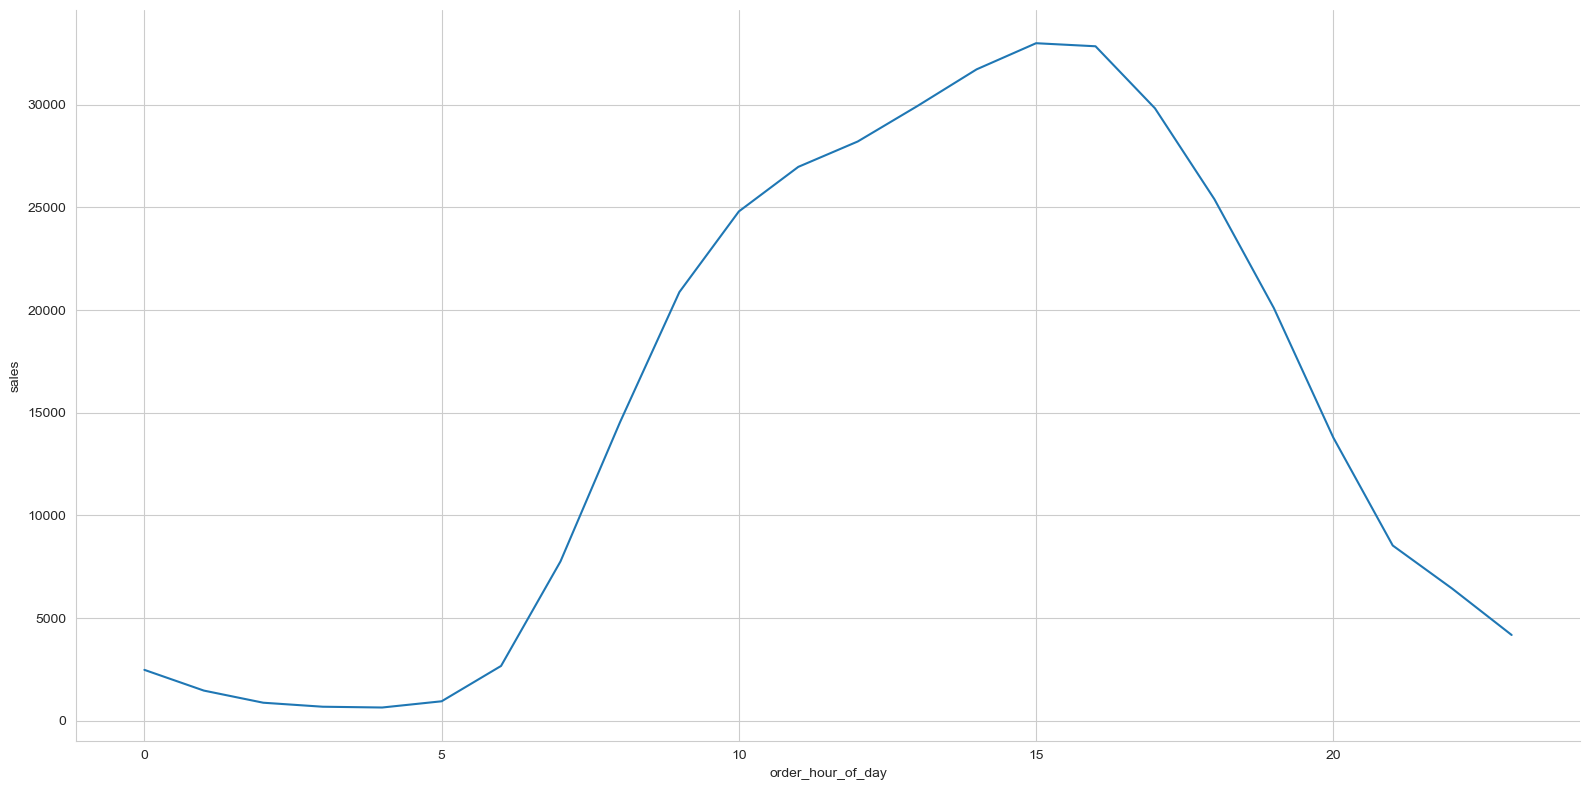

In [43]:
sns.set_style("whitegrid")
sns.relplot(data=hod_to_sales, x="order_hour_of_day", y="sales", kind="line", height=8, aspect=2, palette="hls")

People buy more ice cream in the afternoon

Turn days since order 1 into buckets by adding weeks since first order column

In [44]:
ice_cream_orders.loc[:, "weeks_since_order_1"] = np.floor(ice_cream_orders.loc[:, "days_since_order_1"] / 7)
ice_cream_orders.head()

/var/folders/71/jllnlvwn0gv1k0610m4_0dvh0000gn/T/ipykernel_12951/4089602176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ice_cream_orders.loc[:, "weeks_since_order_1"] = np.floor(ice_cream_orders.loc[:, "days_since_order_1"] / 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_order_1,weeks_since_order_1
25,1492625,2,train,15,1,11,30.0,228.0,32.0
29,2037211,3,prior,4,2,18,20.0,50.0,7.0
30,2710558,3,prior,5,0,17,12.0,62.0,8.0
33,3225766,3,prior,8,0,17,7.0,83.0,11.0
34,3160850,3,prior,9,0,16,7.0,90.0,12.0


In [45]:
weeks_to_sales = ice_cream_orders.groupby("weeks_since_order_1")["order_id"].count()
weeks_to_sales.rename("sales", inplace=True)
weeks_to_sales = pd.DataFrame(weeks_to_sales)
weeks_to_sales.reset_index(inplace=True)
weeks_to_sales.head()

,weeks_since_order_1,sales
0,0.0,31266
1,1.0,12434
2,2.0,12208
3,3.0,11981
4,4.0,17273


/Users/simonxu/opt/anaconda3/envs/ml_practice/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


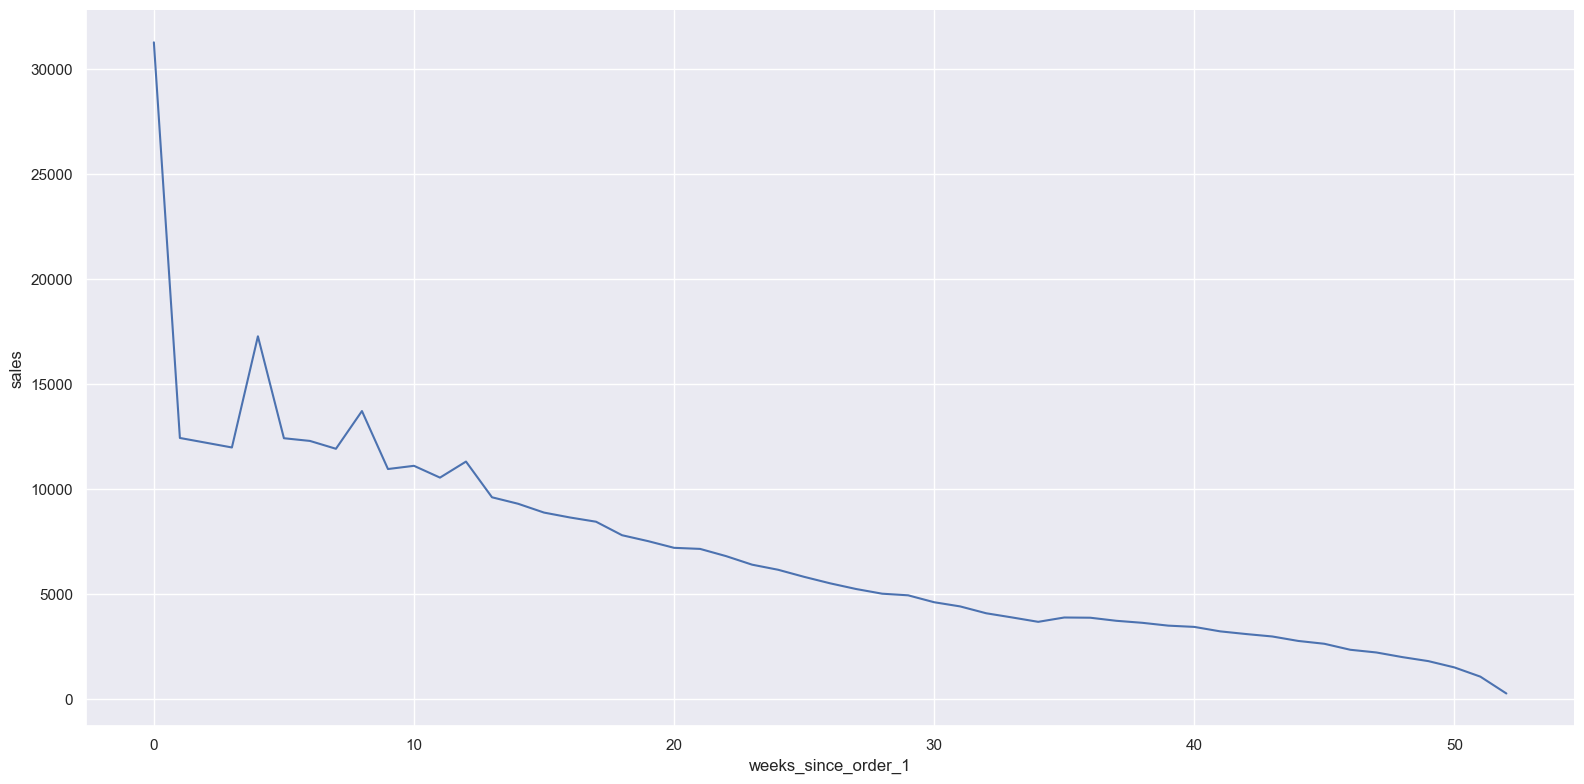

In [46]:
sns.set_theme()

sns.relplot(data=weeks_to_sales, x="weeks_since_order_1", y="sales", kind="line", height=8, aspect=2)

People buy

In [47]:
dow_to_sales = ice_cream_orders.groupby(["weeks_since_order_1","order_dow", "order_hour_of_day"])["order_id"].count().unstack()
dow_to_sales.reset_index(inplace=True)
dow_to_sales.head(100)

order_hour_of_day,weeks_since_order_1,order_dow,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0,26.0,31.0,19.0,11.0,12.0,12.0,27.0,63.0,...,553.0,566.0,567.0,524.0,366.0,271.0,200.0,117.0,108.0,51.0
1,0.0,1,28.0,17.0,9.0,6.0,12.0,7.0,35.0,66.0,...,366.0,409.0,419.0,363.0,326.0,288.0,181.0,103.0,68.0,50.0
2,0.0,2,19.0,16.0,11.0,7.0,8.0,12.0,25.0,75.0,...,296.0,315.0,336.0,338.0,323.0,256.0,199.0,96.0,67.0,43.0
3,0.0,3,28.0,16.0,7.0,8.0,9.0,11.0,34.0,65.0,...,297.0,328.0,342.0,335.0,304.0,272.0,168.0,74.0,73.0,60.0
4,0.0,4,24.0,22.0,12.0,4.0,2.0,8.0,24.0,76.0,...,296.0,356.0,327.0,307.0,309.0,258.0,177.0,98.0,78.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,13.0,4,8.0,3.0,5.0,4.0,1.0,4.0,13.0,24.0,...,85.0,96.0,110.0,92.0,87.0,76.0,50.0,43.0,25.0,14.0
96,13.0,5,14.0,5.0,2.0,2.0,3.0,4.0,12.0,22.0,...,114.0,114.0,127.0,112.0,85.0,80.0,42.0,23.0,23.0,12.0
97,13.0,6,10.0,12.0,3.0,2.0,2.0,3.0,9.0,30.0,...,140.0,141.0,151.0,109.0,109.0,64.0,47.0,26.0,35.0,10.0
98,14.0,0,4.0,5.0,7.0,2.0,2.0,6.0,6.0,26.0,...,183.0,144.0,162.0,125.0,93.0,91.0,59.0,30.0,18.0,16.0


In [48]:
week_dow_to_sales = dow_to_sales.melt(id_vars=["weeks_since_order_1", "order_dow"], value_vars=[0, 1, 2, 3, 4, 5, 6], var_name="order_dow", value_name="sales")
week_dow_to_sales.fillna(0)
week_dow_to_sales.columns = ["weeks_since_order_1", "order_dow", "remove", "sales"]
week_dow_to_sales.drop(columns=["remove"], inplace=True)
week_dow_to_sales.head()

,weeks_since_order_1,order_dow,sales
0,0.0,0,26.0
1,0.0,0,28.0
2,0.0,0,19.0
3,0.0,0,28.0
4,0.0,0,24.0


In [49]:
week_dow_to_sales["months_since_order_1"] = np.ceil(week_dow_to_sales["weeks_since_order_1"]/4)
week_dow_to_sales.head()

,weeks_since_order_1,order_dow,sales,months_since_order_1
0,0.0,0,26.0,0.0
1,0.0,0,28.0,0.0
2,0.0,0,19.0,0.0
3,0.0,0,28.0,0.0
4,0.0,0,24.0,0.0


/Users/simonxu/opt/anaconda3/envs/ml_practice/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/simonxu/opt/anaconda3/envs/ml_practice/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/simonxu/opt/anaconda3/envs/ml_practice/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/simonxu/opt/anaconda3/envs/ml_practice/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/simonxu/opt/anaconda3/envs/ml_practice/lib/python3.10/site-packages/seaborn/axisgrid.

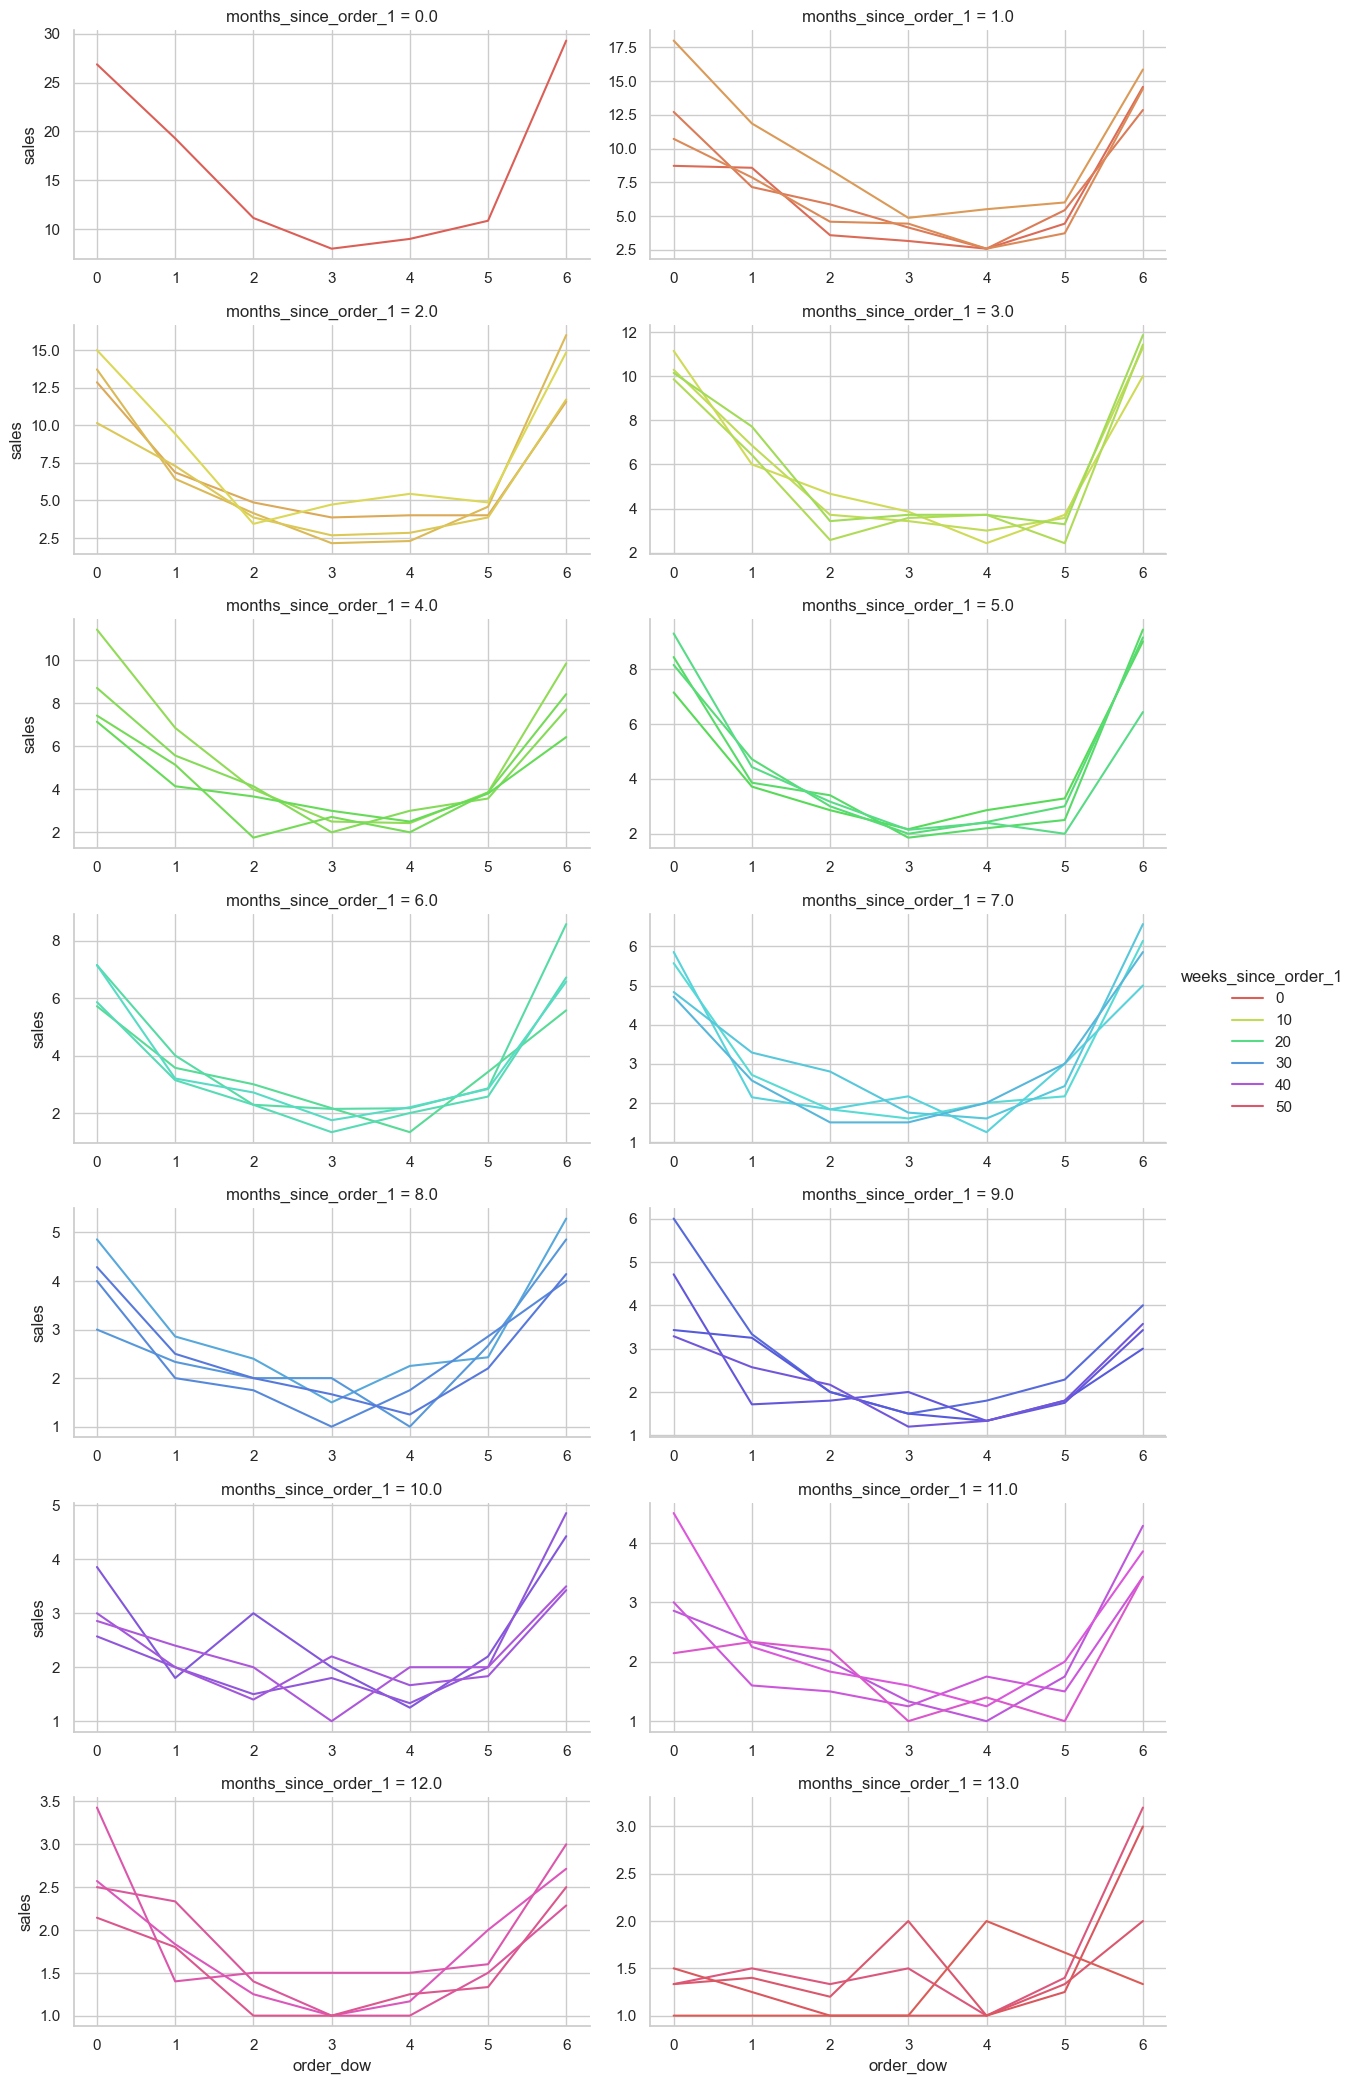

In [50]:
sns.set_style("whitegrid")
sns.relplot(data=week_dow_to_sales, x="order_dow", y="sales", col="months_since_order_1", col_wrap=2, hue="weeks_since_order_1", kind="line", facet_kws={'sharey': False, 'sharex': False}, height=3, aspect=2, palette="hls", ci=None)

No matter how many months since their first order, customers buy more ice cream on the weekends
